# **Experimenting with a Linear Physics-Informed Neural Network (PINN)**

## **Problem Description and Goal**



In this notebook we build a linear PINN using PyTorch that aims to fit synthetic data with Gaussian noise around the line:

<br>\begin{equation} y = m(x) = ax + b \end{equation}<br>

Fundamentally, the model looks for a solution consistent with the differential equation:

<br>\begin{equation} \frac{d^2m}{dx^2} = 0 \end{equation}<br>

This equation incorporates our prior information that the data has a linear relationship. The approach of bringing prior knowledge into the model's training classifies it as a PINN.

<br>

We also experiment with the regularization parameter as well as the model architecture (layers and neurons) to better understand their impact.







## **Workflow**

1. Set up environment

2.   Generate noisy synthetic data

3.   Set up neural network

4. Set up training

5. Train model

6. Calculate error over different intervals

7. Modify regularization term

8. Modify differential equation

9. Modify # of layers and neurons

## **1. Set up environment**
Here we mount Google Drive so that we can save future figures to a folder.





In [1]:
# Importing libraries for Google Drive access
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set up location for storing images
images_dir = '/content/drive/MyDrive/simplenn_data/general_runs'

Mounted at /content/drive


We then import PyTorch and some other libraries within it, NumPy, and Matplotlib.

<br>

### **Uses of each library**
*   PyTorch helps us store data in tensors and set up the neural network
*   NumPy helps us convert tensors into an appropriate format for plotting
*  Matplotlib helps us create nice plots

In [2]:
# Importing other libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split

## **2. Generate noisy synthetic data**

The ground truth line is $y = ax + b$.

In [3]:
# Defines a line as the ground truth function
def ground_truth(x):
  return a * x + b

We choose the coefficients $a = 1$ and $b = 1$, making the ground truth line $y = x + 1$. This choice was arbritary but serves our purpose of modeling linear data.

<br>

We generate 10 values of Gaussian noise with mean 0 and variance 0.01. We also generate 10 x values between 0 and 1. Then, we add the noise to corresponding y values of our ground truth line. This results in 10 pairs of x and y values that vaguely follow the line's pattern.

In [4]:
# Coefficients for line y = ax + b
a = 1
b = 1

# Creates Gaussian noise with mean 0 and variance 0.01 for 10 points
n = 10
g_noise = torch.randn(n,1) * np.sqrt(0.01)

# Generates n number of points between 0 and 1
X = torch.linspace(0, 1, n).view(-1,1)

# Generates y values for corresponding x values and adds Gaussian noise
Y = ground_truth(X) + g_noise

# Combines x and y values into a TensorDataset
dataset = TensorDataset(X, Y)

Here we plot the data and the ground truth line on the interval $[-1, 2]$. We will later evaluate the model on this larger interval to understand its performance on values outside of the training data.

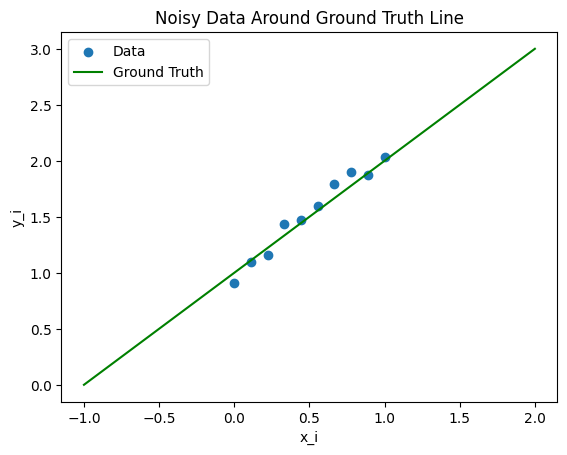

In [5]:
# Generates x values inside and outside of the initial range
x_plot = torch.linspace(-1, 2, 100).view(-1, 1)

# Plots the noisy data points and ground truth line together
plt.scatter(X.numpy(), Y.numpy(), label='Data')
plt.plot(x_plot.numpy(), ground_truth(x_plot).numpy(), color='green', label='Ground Truth')
plt.xlabel('x_i')
plt.ylabel('y_i')
plt.legend()
plt.title("Noisy Data Around Ground Truth Line")
plt.savefig(f"{images_dir}/noisy_data_truth.png")
plt.show()

## **3. Set up neural network**



We set up the notebook such that batch size can be manipulated in the future, but at the moment it is equal to the number of training points.

In [6]:
# Sets up batches in DataLoader
batch_size = 10
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

We define a class for the neural network. It takes in the number of layers and number of neurons per layer. There is always one input and one output, which resembles a linear function that takes in one x value and returns one y value.

<br>

The `forward()` function performs a pass through the network using the Tanh activation function.

<br>

The `compute_derivatives()` function computes first and second derivatives, which is useful for getting the residual for the loss function as well as plotting their values for a given neural network.

In [7]:
# Creates neural network class
class Net(nn.Module):
    # Constructor defines the layers
    def __init__(self, d, w):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(1, w))

        # Hidden layer
        for i in range(d-2):
          self.layers.append(nn.Linear(w, w))

        # Output layer
        self.layers.append(nn.Linear(w, 1))

    # Pass through network
    def forward(self, x):
        # Applying Tanh to all layers except the last
        for layer in self.layers[:-1]:
          x = torch.tanh(layer(x))

        # Pass through last
        x = self.layers[-1](x)

        return x

    # Computes first and second derivatives using automatic differentation
    def compute_derivatives(self, x_input):
      first_derivative = torch.autograd.grad(outputs=self(x_input), inputs=x_input,
                                               grad_outputs=torch.ones_like(self(x_input)),
                                               create_graph=True, retain_graph=True)[0]
      second_derivative = torch.autograd.grad(outputs=first_derivative, inputs=x_input,
                                              grad_outputs=torch.ones_like(first_derivative),
                                              create_graph=True, retain_graph=True)[0]
      return first_derivative, second_derivative

Here we create a model with 2 layers and 10 neurons per layer. This is the neural network we will start with. At the end of this notebook, we will play around wtih those values to see how the performance changes.

<br>

We will be using mean squared error (MSE) as our loss function and the Adam optimizer.

In [8]:
# 2 layers, 10 neurons per layer
d, w = 2, 10
# Define instance of network
model = Net(d, w)
# MSE loss function
criterion = nn.MSELoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters())

## **4. Set up training**


Now that we have our model architecture, we need to train it on the data. To do so, we pass through the data many times (# of epochs). Within each epoch, we pass through each batch, which is the whole dataset right now.

<br>

First, we reset the gradients. Then, we pass the data through the model and calculate the loss of its predictions against the data points.

<br>

With automatic differentation, we calculate the first and second derivatives to find the residual (the second derivative). We take the mean of its square to further penalize high values. That value is multiplied by a regularization paramater $\lambda$ which allows us to manipulate how much the residual is penalized.

<br>

The total loss is thus the data loss added to the differential equation loss. We then track the loss of each epoch.

In [9]:
# Trains model using given loss function, optimizer, # of epochs, and regularization parameter
def train(model, criterion, optimizer, epochs, lamda_reg):
    # List to keep track of loss
    losses = []

    # Looping through epochs
    for epoch in range(epochs):
        model.train()
        for x, y in dataloader: # Looping through batches
          x.requires_grad = True

          optimizer.zero_grad() # Zero the gradients
          outputs = model(x) # Pass through model
          mse = criterion(outputs, y) # Calculate data loss

          # Compute derivatives
          first_derivative, second_derivative = model.compute_derivatives(x)

          reg_term = second_derivative.pow(2).mean() # Differential equation loss (penalize high values of second derivative)
          total_loss = mse + lamda_reg * reg_term # Total loss = data loss + differential equation loss

          total_loss.backward() # Calculate gradients of loss function

          optimizer.step() # Step weights and biases according to gradients

          losses.append(total_loss.item()) # Total the losses

        # The code below can be uncommented to get information epoch by epoch
        #if epoch % 100 == 0:
          #print(f"Epoch {epoch+1}, total: {total_loss.item()}, mse: {mse.item()}, reg: {reg_term.item()}")
    return losses


## **5. Train model**

We train the model over 5000 epochs, and for now, we set the regularization parameter $\lambda$ to 1.0.

In [10]:
epochs = 5000
reg = 1.0
losses = train(model, criterion, optimizer, epochs, reg)


The plot below illustrates the model's loss throughout the training period of 5000 epochs. It appears to decrease exponentially with the earlier epochs resulting in steeper declines.

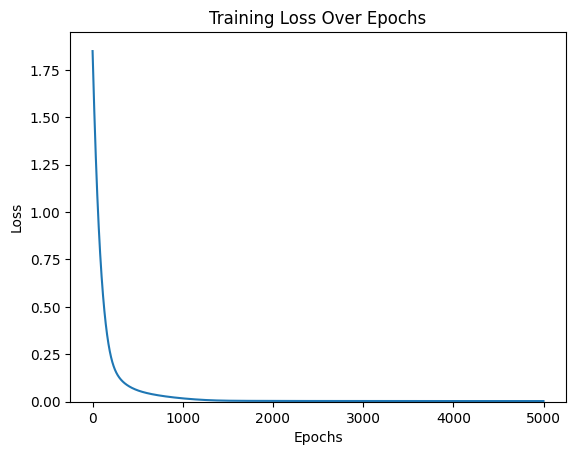

In [11]:
# Plots the training loss over all epochs
plt.plot(np.arange(len(losses)), losses)
plt.ylim(0, max(losses)+0.1)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f"{images_dir}/loss_epochs.png") # Saves figure to Google Drive
plt.show()

Below you can see how the neural network performs in comparison to the noisy  data points and ground truth line. Each run of this notebook will result in slightly different performance, but the neural network should resemble the line.

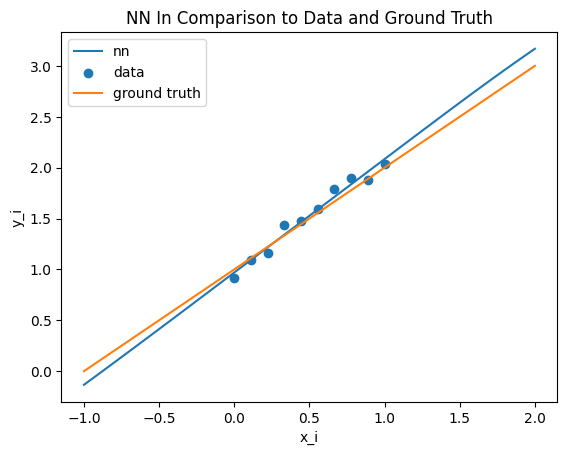

In [23]:
# Pass data on [1, 2] through neural network
y_plot = model(x_plot)

# Plots neural network
plt.plot(x_plot.detach().numpy(), y_plot.detach().numpy(), label='nn')
# Plots initial data points
plt.scatter(X.detach().numpy(), Y.detach().numpy(), label='data')
# Plots ground truth line
plt.plot(x_plot.detach().numpy(), ground_truth(x_plot).detach().numpy(), label='ground truth')

plt.xlabel('x_i')
plt.ylabel('y_i')
plt.title('NN In Comparison to Data and Ground Truth')
plt.legend()
plt.savefig(f"{images_dir}/data_nn_groundtruth.png") # Saves figure to Google Drive
plt.show()

**Note that the neural network is mostly linear, even outside of the interval it was trained on ($[0, 1]$).** This is because it's a PINN! Remember our differential equation that corresponds to $m(x)$ being a line:

<br> \begin{equation}\frac{d^2m}{dx^2} = 0\end{equation} <br>

When we penalize high values of the second derivative in our loss function, we are telling the model that our data has a linear relationship. This framework forces the model to be a straight line even when it has no knowledge about that interval.

<br>

While the neural network is straight outside of the interval, it may not perform as well with respect to the ground truth line. Let's take a look.

## **6. Calculate error over different intervals**

It's important to understand how the model performs outside of its training range.

<br>

We calculate the MSE in three different ways.


1.   Over the whole interval $[-1, 2]$
2.   Over the training interval $[0, 1]$
3.   Outside of the training interval $[0, 1]$

<br>

We expect the training interval loss to be higher than the loss outside of that interval (although exceptions are possible). While implementing the residual does improve the model on data outside of the range, it's not perfect and the loss values will likely reflect that.

<br>

Below are the calculations:

In [13]:
# Calculates error over [-1, 2] interval using criterion (MSE)
x_overall = torch.linspace(-1, 2, 300).view(-1, 1)
y_overall = model(x_overall)
y_ground_truth = ground_truth(x_overall)
mse_ground_truth = criterion(y_overall, y_ground_truth).item()
print('MSE for [-1, 2]: ', mse_ground_truth)

# Calculates MSE inside interval [0, 1]
x_interval = torch.linspace(0, 1, 100).view(-1,1)
y_interval = ground_truth(x_interval)
y_interval_net = model(x_interval)
mse_interval = criterion(y_interval_net, y_interval).item()
print('MSE for [0, 1]: ', mse_interval)

# Calculates MSE outside interval [0, 1]
x_bound1 = torch.linspace(-1, 0, 100).view(-1,1)
x_bound2 = torch.linspace(1, 2, 100).view(-1,1)
x_bounds = torch.cat((x_bound1, x_bound2), 0)
y_bounds = ground_truth(x_bounds)
y_bounds_net = model(x_bounds)
mse_outside = criterion(y_bounds_net, y_bounds).item()
print('MSE for [-1, 0]∪[1, 2]: ', mse_outside)



MSE for [-1, 2]:  0.009242617525160313
MSE for [0, 1]:  0.001873551867902279
MSE for [-1, 0]∪[1, 2]:  0.012876245193183422


Now that we have a working model, we can play around with it.

## **7. Modify regularization parameter**

An important aspect of a PINN is $\lambda$, the regularization parameter. Again, this value controls how much we assume that the data is consistent with the differential equation.

<br>

We analyze the model for $\lambda = 1.0, 10^{-6}, 10.0$

To do so, we initialize 3 models with the same optimizer (Adam) and layer and neuron configuration (2 layers, 10 neurons per layer). We just modify their regularization parameters.

In [14]:
reg_terms = [1.0, 1e-6, 10.0] # 3 different values for lambda
x_plot.requires_grad=True # This is necessary to compute derivatives for residual

# Initialize models and optimizers
models = [Net(d, w) for _ in range(len(reg_terms))]
optimizers = [optim.Adam(model.parameters()) for model in models]

For each $\lambda$ value, we train its corresponding model.

In [15]:
# Train all models according to their regularization parameter
for i, reg_term in enumerate(reg_terms):
    train(models[i], criterion, optimizers[i], epochs, reg_term)

In the plot below, we see how the regularization parameter impacts the neural network.




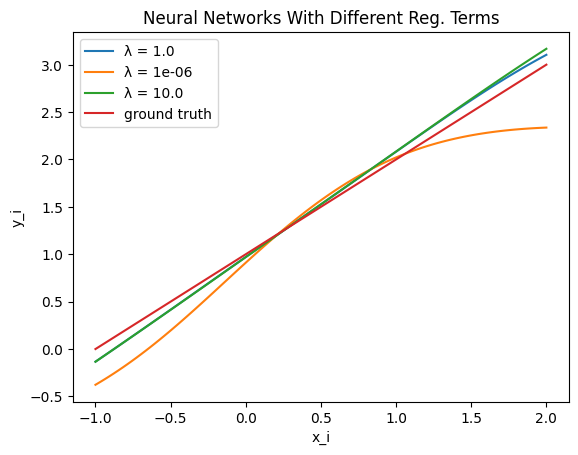

In [16]:
# Plots model for each regularization term
for i, model in enumerate(models):
  plt.plot(x_plot.detach().numpy(), model(x_plot).detach().numpy(), label=f'λ = {reg_terms[i]}')
plt.plot(x_plot.detach().numpy(), ground_truth(x_plot).detach().numpy(), label='ground truth') # Plots ground truth line

plt.xlabel('x_i')
plt.ylabel('y_i')
plt.legend()
plt.title('Neural Networks With Different Reg. Terms')
plt.savefig(f"{images_dir}/reg_changes.png") # Saves figure to Google Drive
plt.show()


We can see that $\lambda$ impacts the accuracy of the neural network.

<br>

For a $\lambda$ of $10^{-6}$, the model behaves as if it does not know that the data is linear. Outside of $[0, 1]$, the model curves and strays from the ground truth line.

<br>

The neural networks wtih $\lambda = 1.0$ and $\lambda = 10.0$ perform similarly, making it difficult to tell which one is more optimal. They are, however, more accurate than $\lambda = 10^{-6}$. To get a better sense of the nuances, we can look at the first and second derivatives.

A good model would have a first derivative that is a constant and a second derivative that is 0. We can use this metric to compare regularization parameters. The graphs are below:

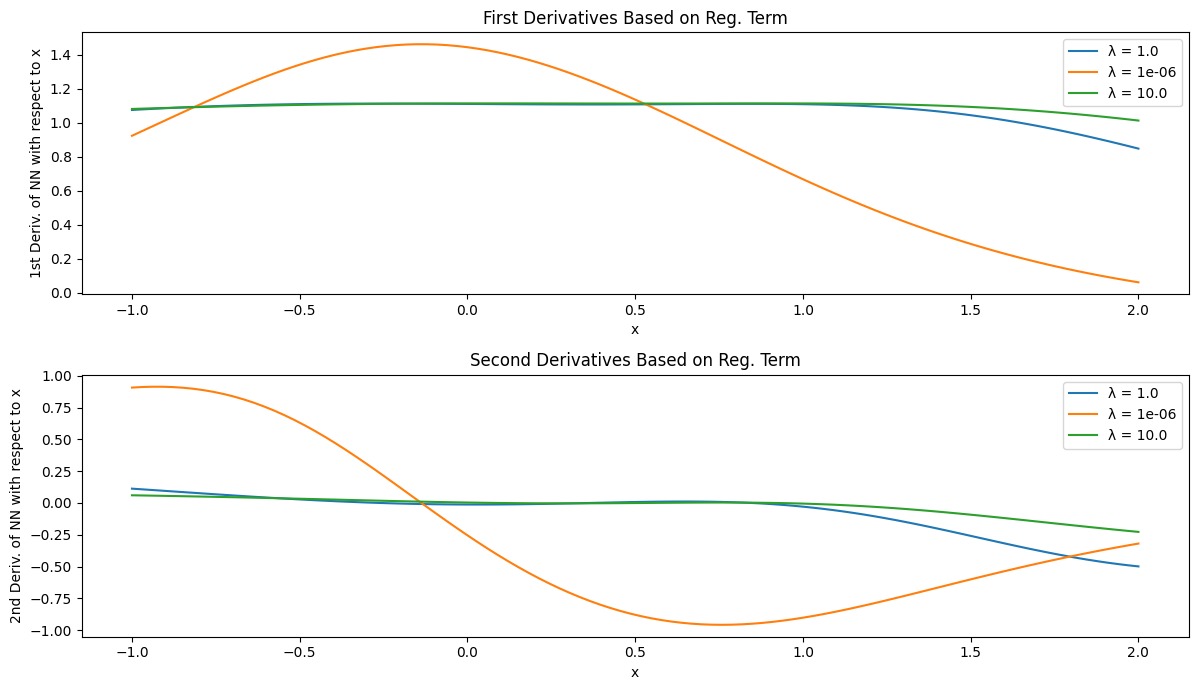

In [17]:
plt.figure(figsize=(12, 7))

# Plots first and second derivatives for each model (and lambda)
for i, model in enumerate(models):
    first_deriv, second_deriv = model.compute_derivatives(x_plot)

    plt.subplot(2, 1, 1)
    plt.plot(x_plot.detach().numpy(), first_deriv.detach().numpy(), label=f'λ = {reg_terms[i]}')
    plt.legend()
    plt.title("First Derivatives Based on Reg. Term")
    plt.xlabel('x')
    plt.ylabel('1st Deriv. of NN with respect to x')


    plt.subplot(2, 1, 2)
    plt.plot(x_plot.detach().numpy(), second_deriv.detach().numpy(), label=f'λ = {reg_terms[i]}')
    plt.legend()
    plt.title("Second Derivatives Based on Reg. Term")
    plt.xlabel('x')
    plt.ylabel('2nd Deriv. of NN with respect to x')

plt.tight_layout()
plt.savefig(f"{images_dir}/reg_derivs.png") # Saves figure to Google Drive
plt.show()


Above we see that the $\lambda = 10^{-6}$ model does not follow our desired trend. This bad performance was visible in the previous graph as well.

<br>

The other two $\lambda$ values *do* roughly follow our desired trend. However, they are not that different from each other. From run to run, performance can vary. Our takeaway is that $\lambda = 1.0$ is a good value, but $\lambda = 10.0$ can be as well.

## **8. Modify differential equation**

Now that we understand $\lambda$ better, we should think about the impact of our choice of differential equation. What if we use the third derivative instead of the second? Then, we would have
\begin{equation}\frac{d^3m}{dx^2}=0\end{equation}
This equation corresponds to both a line and a parabola. Let's see how the model performs.

<br>

Here we modify our prior `train()` function to penalize the third derivative. We also create a new model and train it according to these new conditions. We then calculate MSE over $[-1, 2]$ and plot the model against the ground truth function.


MSE over [-1, 2] for 3rd Deriv Reg: 0.04163231700658798


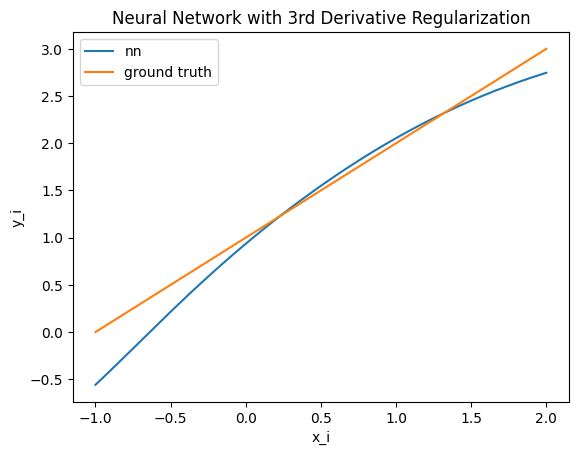

In [18]:
# Trains model using 3rd derivative for regularization
# Same as train() except for derivatives
def train_deriv3(model, criterion, optimizer, dataloader, epochs, lamda_reg):
    losses = []
    for epoch in range(epochs):
        model.train()
        for x, y in dataloader:
          x.requires_grad = True
          optimizer.zero_grad()
          outputs = model(x)
          mse = criterion(outputs, y)

          first_deriv, second_deriv = model.compute_derivatives(x)
          # NEW: computing third derivative of output with respect to input
          third_derivative = torch.autograd.grad(second_deriv, x, grad_outputs=torch.ones_like(second_deriv), create_graph=True, retain_graph=True)[0]

          reg_term = third_derivative.pow(2).mean() # Penalizes high values of third derivative
          total_loss = mse + lamda_reg * reg_term

          total_loss.backward()
          optimizer.step()

          losses.append(total_loss.item())
        # The code below can be uncommented to get information epoch by epoch
        # if epoch % 100 == 0:
        #   print(f"Epoch {epoch+1}, total: {total_loss.item()}, mse: {mse.item()}, reg: {reg_term.item()}")
    return losses

# Creates new model to train
model_deriv3 = Net(d, w)
optimizer = optim.Adam(model_deriv3.parameters())

train_deriv3(model_deriv3, criterion, optimizer, dataloader, epochs, 1) # Trains model using 3rd derivative residual
y_net_deriv3 = model_deriv3(x_overall) # Passes data through model for plotting

print('MSE over [-1, 2] for 3rd Deriv Reg:', criterion(y_net_deriv3, y_ground_truth).item()) # Calculates MSE over [-1, 2]

# Plots new neural network against ground truth
plt.plot(x_overall.detach().numpy(), y_net_deriv3.detach().numpy(), label='nn')
plt.plot(x_overall.detach().numpy(), ground_truth(x_overall).detach().numpy(), label='ground truth')
plt.xlabel('x_i')
plt.ylabel('y_i')
plt.title('Neural Network with 3rd Derivative Regularization')
plt.legend()
plt.savefig(f"{images_dir}/3rd_deriv_net.png") # Saves figure to Google Drive
plt.show()

The plot above shows us that a 3rd derivative residual is not as effective. It seems like the model is trying to fit a quadratic shape to this data, which makes sense because any function $y = ax^2 + bx + c$ is consistent with the 3rd derivative. We can conclude that using the second derivative for our differential equation is optimal.

## **9. Modify layers and neurons**

The last thing we will explore in this notebook is the number of layers and neurons. Our choice of 2 layers and 10 neurons may have seemed random at first, but the following code cells will illustrate their effectiveness.

<br>

To start, we define 3 neural networks with the Adam optimizer and the following configurations respectively:


1.   1 layer, 1 neuron
2.   2 layers, 10 neurons
3.   10 layers, 50 neurons

These three models will give us a sense of how much complexity this problem requires. We train them all over 5000 epochs.


In [19]:
# Model 1 - 1 layer, 1 neuron
model_test1 = Net(1, 1)
optimizer = optim.Adam(model_test1.parameters())
l1 = train(model_test1, criterion, optimizer, 5000, 1)

# Model 2 - 2 layers, 10 neurons
model_test2 = Net(2, 10)
optimizer = optim.Adam(model_test2.parameters())
l2 = train(model_test2, criterion, optimizer, 5000, 1)

# Model 3 - 10 layers, 50 neurons
model_test3 = Net(10, 50)
optimizer = optim.Adam(model_test3.parameters())
l3 = train(model_test3, criterion, optimizer, 5000, 1)

We then pass some data through the models and plot them individually against the ground truth line.

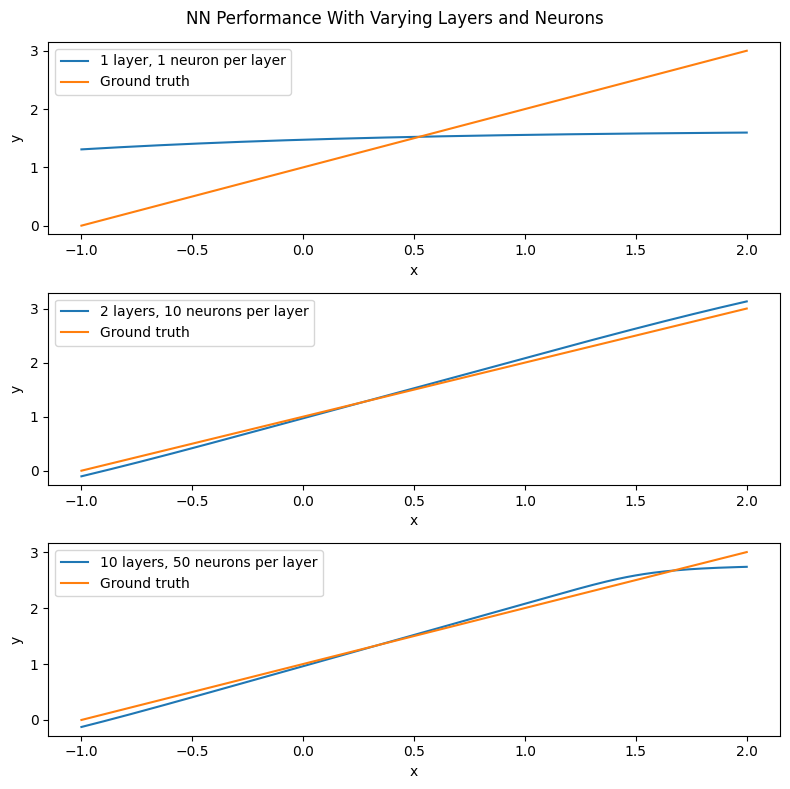

In [20]:
# Passes data through all models
y_net_test1 = model_test1(x_overall)
y_net_test2 = model_test2(x_overall)
y_net_test3 = model_test3(x_overall)

y_net_tests = [y_net_test1, y_net_test2, y_net_test3] # Adds results to an array for future plotting
ln = [[1, 1, ''], [2, 10, 's'], [10, 50, 's']] # Array indicating number of layers and neurons. Final element is whether to make the words 'layer' and 'neuron' plural

# Plots each model against ground truth function
plt.figure(figsize=(8, 8))
for i in range(len(y_net_tests)):
  plt.subplot(3, 1, i+1)
  plt.plot(x_overall.detach().numpy(), y_net_tests[i].detach().numpy(), label=f'{ln[i][0]} layer{ln[i][2]}, {ln[i][1]} neuron{ln[i][2]} per layer')
  plt.plot(x_overall.detach().numpy(), ground_truth(x_overall).detach().numpy(), label='Ground truth')
  plt.legend()
  plt.xlabel('x')
  plt.ylabel('y')

plt.suptitle('NN Performance With Varying Layers and Neurons')
plt.tight_layout()
plt.savefig(f"{images_dir}/layers_neurons.png") # Saves figure to Google Drive
plt.show()

The first model is not able to capture the relationship between the data. It is too simple.

<br>

The third model fits the data well, but for $x > 1.5$, it starts to lose the linearity. This may be due to overfitting.

<br>

The second model is just right. We can see that neural network architecture impacts how much the model captures the data trends. By optimizing the number of layers and neurons, we can obtain a strong model.

## **Conclusion**

This linear PINN was successful and shows us the power of implementing prior knowledge into machine learning models. Adding the residual loss allowed the models to see the bigger picture and predict accurately outside of the range even with sparse training data. Our later experimentation with the regularization parameter, differential equation, and layers and neurons provided further insight about how these PINNs work.  